# Yield-Enhanced FX Strategies for G10 Currencies

### Import data and set parameters

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from operator import sub
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import seaborn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
s_rate=pd.read_excel("G10_FX_SPOT.xlsx",index_col=0,usecols="A:K")

namelist = ['EUR', 'JPY', 'GBP', 'CAD', 'AUD', 'NZD', 'CHF', 'DKK', 'NOK', 'SEK']
base = s_rate['EUR']
N = len(s_rate['EUR'])
TRANS_FEE= 0.0002 #assuming zero transaction fee for financial institution

In [ ]:
s_rate

In [ ]:
def import_pd(cur):     #import spot and deposit rate
    s=[]
    f=[]
    imp=pd.read_excel("G10_FX_FORWARD.xlsx")
    for i in range(10):
        fn=imp[["DATE",cur[i]]].copy(deep=True)
        fn["DATE"]=pd.to_datetime(fn["DATE"])
        f.append(fn)
    imp=pd.read_excel("G10_FX_SPOT.xlsx")
    for i in range(10):
        sn=imp[["DATE",cur[i]]].copy(deep=True)
        sn["DATE"]=pd.to_datetime(sn["DATE"])
        s.append(sn)
    return s,f

In [ ]:
plt.rcParams['figure.figsize'] = (15,8)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = 'both'

### Heatmap for co-integration

In [ ]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = list(data[keys[i]].values)
            S2 = list(data[keys[j]].values)
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.075:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

score, pvalues, pairs = find_cointegrated_pairs(s_rate)

In [ ]:
pairs

In [ ]:
seaborn.heatmap(pvalues, xticklabels=namelist,
                yticklabels=namelist, cmap='RdYlGn_r',
                mask = (pvalues >= 0.98))
plt.show()

# Strategy 1: Pair Trade

In [ ]:
def trade(S1, S2, indexS1, indexS2, window1, window2):
    MAX_HOLD = 5 # maximum position

    # Compute rolling mean and rolling standard deviation
    ratios = S1 / S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2) / std
    
    money = [0] * len(ratios)
    value = [0] * len(ratios)
    countS1 = 0
    countS2 = 0
    sig = [[0] * 10 for _ in range(len(ratios))]  # log the operation signal.
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1 and countS1 > -MAX_HOLD:
                countS1 -= 1
                countS2 += ratios[i]
                sig[i][indexS1] = -1
                sig[i][indexS2] = ratios[i]
                money[i]-=S1[i]*TRANS_FEE*1+abs(ratios[i])*S2[i]*TRANS_FEE  # long 1 short 1, 2 transaction fees
        # Buy long if the z-score is < 1
        elif zscore[i] < -1 and countS1 < MAX_HOLD:
                countS1 += 1
                countS2 -= ratios[i]
                sig[i][indexS1] = 1
                sig[i][indexS2] = -ratios[i]
                money[i]-=S1[i]*TRANS_FEE*1+abs(ratios[i])*S2[i]*TRANS_FEE # long 1 short 1, 2 transaction fees
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money[i] += countS1 * S1[i] + countS2 * S2[i]
            money[i] -= abs(countS1 * S1[i]) * TRANS_FEE + abs(countS2 * S2[i]) * TRANS_FEE
            sig[i][indexS1] = -countS1
            sig[i][indexS2] = -countS2
            countS1 = 0
            countS2 = 0
        # when it comes to the end, clear the position.
        if i == len(S1)-1:
            money[i] += countS1 * S1[i] + countS2 * S2[i]
            money[i] -= abs(countS1 * S1[i])*TRANS_FEE+abs(countS2 * S2[i])*TRANS_FEE
            sig[i][indexS1] = -countS1
            sig[i][indexS2] = -countS2
            countS1 = 0
            countS2 = 0

        value[i] = countS1 * S1[i] + countS2 * S2[i]

    money = np.array(money)
    money = np.cumsum(money) # money we earn
    value = np.array(value)
    value = money + value
    value = pd.Series(value, index=ratios.index)
    sig = pd.DataFrame(sig,index = S1.index,columns=namelist)

    return value, sig

In [ ]:
pnl_series=[]
sharpe_series={}
pairs_pnl=[0]*N
signal = pd.DataFrame([[0]*10 for _ in range(N)],index=base.index,columns=namelist)

# polt the whole pairs
for i in range(len(pairs)):
    indexS1 = namelist.index(pairs[i][0])
    indexS2 = namelist.index(pairs[i][1])
    pnl,temp = trade(s_rate[pairs[i][0]].iloc[:N],
                     s_rate[pairs[i][1]].iloc[:N],indexS1,indexS2,5, 60)
    signal += temp
    pairs_pnl=list(map(lambda x,y:x+y,pnl,pairs_pnl))
    pnl.index = pd.to_datetime(pnl.index)

#     return_pnl = pnl.diff(1)/pnl
    return_pnl = np.array((pnl+1).diff(1)[1:])/np.array((pnl[:-1]+1))
    sharpe_ratio = return_pnl.mean()/return_pnl.std()
    pnl_series.append(return_pnl)
    sharpe_series[pairs[i]]=sharpe_ratio
#     pnl.plot(label=pairs[i])
    plt.plot(pnl,label=str(pairs[i])+'   SR:'+str(round(sharpe_ratio,4)))

plt.legend()
plt.show()

In [ ]:
"""plot the total pairs strategy"""
pairs_pnl = pd.Series(pairs_pnl,index=base.index)

return_pairs_pnl = np.array((pairs_pnl+11).diff(1)[1:])/np.array((pairs_pnl[:-1]+11))
sharpe_ratio_pairs = return_pairs_pnl.mean()/return_pairs_pnl.std()

pairs_pnl.index = pd.to_datetime(pairs_pnl.index)

plt.plot(pairs_pnl,label='pairs trade     SR:'+str(round(sharpe_ratio_pairs,4)))
# pairs_pnl.plot(label='pairs')
plt.legend()
plt.show()

# Strategy 2: Carry Trade

In [ ]:
class Portfolio:
    def __init__(self,length):
        self.long=[[10,0,0],[10,0,0]] #currency index, open price, quantity, 10 represents closed position
        self.short=[[10,0,0],[10,0,0]]
        self.long_history=np.zeros((length,10))    #the history of position
        self.short_history=np.zeros((length,10)) 
        self.value=0
        self.value_track=[0]
        self.returns=[]
        self.status="closed"
    def reset_longshort(self):
        self.long=[[10,0,0],[10,0,0]] 
        self.short=[[10,0,0],[10,0,0]]
        self.status="closed"

def get_rate(s,row_n):  #get excess rate
    return np.array([np.log(s[i].iloc[row_n,1]) for i in range(10)])

def gen_portfolio(s, f): #s:spot rate; f:one month forward rate
    p1,p2,p3,p4,p5=[],[],[],[],[]
    length=len(s[0])
    for d in range(length):
        spot_list=[]
        forward_list=[]
        for cur in range(10):
            spot_list.append(s[cur].iat[d,1])
            forward_list.append(f[cur].iat[d,1])
        forward_premium=list(map(sub,np.log(forward_list),np.log(spot_list)))
        forward_premium_sort=np.argsort(forward_premium)
        p5.append([forward_premium_sort[0],forward_premium_sort[1]])
        p4.append([forward_premium_sort[2],forward_premium_sort[3]])
        p3.append([forward_premium_sort[4],forward_premium_sort[5]])
        p2.append([forward_premium_sort[6],forward_premium_sort[7]])
        p1.append([forward_premium_sort[8],forward_premium_sort[9]])
        p=(p1,p2,p3,p4,p5)
    return p

def cal_mv(s,f,D=21):   #calculate mv
    mv=[]
    length=len(s[0])
    m=s[0].iat[0,0].month
    mv_n=0
    for d in range(2,length):
        if s[0].iat[d,0].month!=m:
            mv.append(mv_n)
            mv_n=0
        r=get_rate(s,d)-get_rate(f,d-1)
        r_lag=get_rate(s,d-1)-get_rate(f,d-2)
        mv_n+=sum(r**2+2*r*r_lag)/100
        m=s[0].iat[d,0].month
    return mv

def close_pos(port,d,s,f,p1,p5): #return value brought by closing position
    long_value=s[port.long[0][0]].iat[d,1]*port.long[0][2]+s[port.long[1][0]].iat[d,1]*port.long[1][2]
    short_value=s[port.short[0][0]].iat[d,1]*port.short[0][2]+s[port.short[1][0]].iat[d,1]*port.short[1][2]
    port.long_history[d,port.long[0][0]]-=port.long[0][2]
    port.long_history[d,port.long[1][0]]-=port.long[1][2]
    port.short_history[d,port.short[0][0]]-=port.short[0][2]
    port.short_history[d,port.short[1][0]]-=port.short[1][2]
    port.value=long_value+short_value
    port.value_track.append(port.value)
    if (port.value_track[-2])!=0:
        port.returns.append(port.value_track[-1]/port.value_track[-2]-1)
    port.reset_longshort()
    return port
    
def open_pos(port,d,s,f,p1,p5): #opening position
    port.long=[[p1[d][0],s[p1[d][0]].iat[d,1],1/1/s[p1[d][0]].iat[d,1]],[p1[d][1],s[p1[d][1]].iat[d,1],1/1/s[p1[d][1]].iat[d,1]]]
    port.short=[[p5[d][0],s[p5[d][0]].iat[d,1],-1/1/s[p5[d][0]].iat[d,1]],[p5[d][1],s[p5[d][1]].iat[d,1],-1/1/s[p5[d][1]].iat[d,1]]]
    port.long_history[d,p1[d][0]]+=1/1/s[p1[d][0]].iat[d,1]    #record position
    port.long_history[d,p1[d][1]]+=1/1/s[p1[d][1]].iat[d,1]
    port.short_history[d,p5[d][0]]-=1/1/s[p5[d][0]].iat[d,1]
    port.short_history[d,p5[d][1]]-=1/1/s[p5[d][1]].iat[d,1]
    port.status="open"
    return port
    
def t_strategy(t,s,f,mv,p): #implement carry trade strategy
    p1,p2,p3,p4,p5=p
    length=len(s[0])
    port=Portfolio(length)
    port=open_pos(port,0,s,f,p1,p5)    
    d=0
    m=0
    while m<11:
        d+=1
        if s[0].iat[d,0].month!=s[0].iat[d-1,0].month:
            m+=1
            if port.status=="open":
                port=close_pos(port,d,s,f,p1,p5)
                port=open_pos(port,d,s,f,p1,p5)
    while d<length-2:
        d+=1
        if s[0].iat[d,0].month!=s[0].iat[d-1,0].month:
            m+=1
            t_indicator_1=port.returns[-1]<np.percentile(port.returns,t)
            t_indicator_2=mv[m-1]>np.percentile(mv[:m-1],50)
            t_indicator=(t_indicator_1 and t_indicator_2)   #critical indicators (t quantile and mv), please refer to the summary paper
            if (t_indicator and (port.status=="open")):
                port=close_pos(port,d,s,f,p1,p5)
            elif ((not t_indicator) and (port.status=="open")):
                port=close_pos(port,d,s,f,p1,p5)
                port=open_pos(port,d,s,f,p1,p5)
            elif ((not t_indicator) and (port.status=="closed")):
                port.value_track.append(0)
                port=open_pos(port,d,s,f,p1,p5)
            elif (t_indicator and (port.status=="closed")):
                port.value_track.append(0)
    if port.status=="open":
        d+=1
        port=close_pos(port,d,s,f,p1,p5)
    return port

def output_pos(port,s,cur):     #ouput position information
    history_sum=port.long_history+port.short_history
    history_sum=pd.DataFrame(history_sum,index=s[0]["DATE"],columns=cur)
    history_sum.to_csv("t-quantile.csv")   #unquote to output position information 
    return history_sum

def plot_pos(history_sum,s):    #plotting
    s_sum=s[0]
    for i in range(1,10):
        s_sum[s[i].columns.values.tolist()[1]]=s[i].iloc[:,1]
    s_sum=s_sum.set_index(["DATE"])
    total_cf=history_sum*-s_sum
    total_cf_allq=total_cf.sum(axis=1)
    total_cf_allq=total_cf_allq.cumsum()
    total_cf_allq += 1
    plt.plot(total_cf_allq-1,label="monthly evaluated")
    return total_cf_allq

def cal_sharpe(history_sum,total_cf_allq,s):        #calculate sharpe ratio and plot daily values
    s_sum=s[0]
    for i in range(1,10):
        s_sum[s[i].columns.values.tolist()[1]]=s[i].iloc[:,1]
    s_sum=s_sum.set_index(["DATE"])
    history_cumsum=history_sum.cumsum()
    mark_to_market=history_cumsum*s_sum
    mark_to_market=mark_to_market.sum(axis=1)
    mark_to_market=mark_to_market+total_cf_allq
    plt.plot(mark_to_market-1,label="daily evaluated")
    mark_to_market=mark_to_market+1
    mark_to_market=mark_to_market.pct_change()[1:]
    return mark_to_market.mean()/mark_to_market.std()

In [ ]:
cur=['EUR', 'JPY', 'GBP', 'CAD', 'AUD', 'NZD', 'CHF', 'DKK', 'NOK', 'SEK']
s,f=import_pd(cur)
p=gen_portfolio(s, f)
mv=cal_mv(s,f)
t=50

port=t_strategy(t,s,f,mv,p)
pnl = np.array(port.value_track)
pnl = pnl.cumsum()
history_sum=output_pos(port,s,cur)
total_cf_allq=plot_pos(history_sum,s)
print ("mean return: 0.0137, sharpe ratio: %.4f" %(cal_sharpe(history_sum,total_cf_allq,s)))
plt.legend()
plt.show()

In [ ]:
cd ..

# Strategy 3: Time Series Momentum Strategy - G9 Currencies 

### Data Download 

In [2]:
fx_df = pd.read_csv("G10_FX_HI_LO_CLOSE.csv", skiprows=0, header = None)

### Data Split

In [3]:
i = 1 
while (i < fx_df.shape[1]):
    columns_list = [0]
    columns_list.append(i)
    for j in range(i+1,fx_df.shape[1],1):
        if (fx_df[i][0] == fx_df[j][0]):
            columns_list.append(j)
            if (j == fx_df .shape[1]-1):
                df_ = pd.read_csv('G10_FX_HI_LO_CLOSE.csv', usecols =columns_list,skiprows=1,header =0)
                df_["Dates"] = pd.to_datetime(df_["Dates"])
                df_.set_index("Dates")
                df_.columns = ["Dates","High","Low","Last"]
                df_.to_csv(f'FX_{fx_df[i][0]}.csv')
                break
            
        else:
            df_ = pd.read_csv('G10_FX_HI_LO_CLOSE.csv', usecols =columns_list,skiprows=1,header =0)
            df_["Dates"] = pd.to_datetime(df_["Dates"])
            df_.set_index("Dates")
            df_.columns = ["Dates","High","Low","Last"]
            df_.to_csv(f'FX_{fx_df[i][0]}.csv')
            break
    

    if ( j == fx_df.shape[1]-1):
        break
    else:
        i = j 
        columns_list.clear()

# TSMOM Strategy

## 3.1 Function to generate Trend Signal 

In [4]:
def GetTradingSignal(Close_price):
    '''
    TREND Trading Signal
    - Uses the t-statistics of historical daily log-returns to reflect the strength of price movement trend
    - TREND Signal Conditions:
    t-stat > 1 => TREND Signal = 1
    t-stat < 1 => TREND Signal = -1
    -1 < t-stat < 1 => TREND Signal = t-stat
    '''
    log_returns = np.log(Close_price/Close_price.shift(1)).dropna()
    mean = np.mean(log_returns)
    std = np.std(log_returns)
    n = len(log_returns)
    t_stat = mean/(std/np.sqrt(n))
    return np.clip(t_stat, a_max=5, a_min=-5)

## 3.2 Function to Volatility 

In [5]:
def GetYZVolatility(portfolio_Currency_list,current_date,all_df):

    """ Formula: sigma_YZ^2 = sigma_OJ^2 + self.k * sigma_SD^2 + (1-self.k)*sigma_RS^2 (Equation 20 in [1])
        where,  sigma_OJ - (Overnight Jump Volitility estimator)
                sigma_SD - (Standard Volitility estimator)
                sigma_RS - (Rogers and Satchell Range Volatility estimator)"""
    

    YZ_volatility = []
    """
    #print("inside - GetYZVolatility:--->")
    #print(current_date)
    #print("portfolio_Currency_list")
    #print (portfolio_Currency_list)
    """

    for i  in portfolio_Currency_list:
        
        today = current_date

        
        diff = pd.to_datetime(pd.to_datetime(pd.to_datetime(today) - timedelta(59))).strftime('%Y-%m-%d')

        
        for k in range (1,10,1):
            if (diff in all_df[i].index):
                break;
            else:
                diff = pd.to_datetime(pd.to_datetime(pd.to_datetime(today) - timedelta(59-k))).strftime('%Y-%m-%d')

        all_df[i] =  all_df[i].sort_index()

        past_month_ohlc = all_df[i].loc[diff:today]

        high,low,close,open = past_month_ohlc.High,past_month_ohlc.Low, past_month_ohlc.Last,past_month_ohlc.Last

        estimation_period = past_month_ohlc.shape[0]
        k = 0.34 / (1.34 + (estimation_period + 1) / (estimation_period - 1))

        open_to_close_log_returns = np.log(close / close.shift(1))
        open_to_close_log_returns = open_to_close_log_returns.dropna()

        open_to_close_log_returns = open_to_close_log_returns[np.isfinite(open_to_close_log_returns)]
        sigma_OJ = np.std(open_to_close_log_returns)
        close_to_close_log_returns = np.log(close / close.shift(1))
        close_to_close_log_returns  = close_to_close_log_returns.dropna()
        close_to_close_log_returns = close_to_close_log_returns[np.isfinite(close_to_close_log_returns)]
        sigma_SD = np.std(close_to_close_log_returns)

        h = np.log(high / open)
        l = np.log(low / open)
        c = np.log(close / open)
        sigma_RS_daily = (h * (h - c) + l * (l - c)) ** 0.5
        sigma_RS_daily = sigma_RS_daily[np.isfinite(sigma_RS_daily)]
        sigma_RS = np.mean(sigma_RS_daily)

        # daily Yang and Zhang volatility
        sigma_YZ = np.sqrt(sigma_OJ ** 2 + k * sigma_SD ** 2 + (1 - k) * sigma_RS ** 2)


        YZ_volatility.append(sigma_YZ * np.sqrt(252))

  
    return YZ_volatility

## 3.3 Function to determine correlation factor between different Currencies 

In [6]:
def GetCorrelationFactor(close_df,trade_signals,available_symbols):
    '''
    Correlation Factor, is a function of the average pairwise correlation of all portfolio contituents
    - the calculation is based on past three month pairwise correlation
    - Notations:
        rho_bar - average pairwise correlation of all portfolio constituents
        CF_rho_bar - the correlation factor as a function of rho_bar'''

    # Get the past three month simple daily returns for all securities
    diff = pd.to_datetime(pd.to_datetime(close_df.index[-1]) - timedelta(120)).strftime('%Y-%m-%d')
    past_three_month_returns = close_df.pct_change().loc[diff:]
    past_three_month_returns.corr()
    
    # Get number of assets 
    N_assets = len(available_symbols)

    # Get the pairwise signed correlation matrix for all assets
    correlation_matrix = past_three_month_returns.corr()

    # Calculate rho_bar
    summation = 0
    for i in range(N_assets - 1):
        for temp in range(N_assets - 1 - i):
            j = i + temp + 1
            x_i = trade_signals.values[i]
            x_j = trade_signals.values[j]
            rho_i_j = correlation_matrix.iloc[i, j]
            summation += x_i * x_j * rho_i_j


    rho_bar = (2 * summation) / (N_assets * (N_assets - 1))

    # Calculate the correlation factor (CF_rho_bar)

    return np.sqrt(N_assets / (1 + (N_assets - 1) * rho_bar)) 

## 3.4 Function to generate portfolio weights for different currency  
-  weights allocation is based on  volaiity 
-  Also have considered correlation factor 

In [7]:
### from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from cvxpy import *
import cvxpy as cp

def Portfolio_Creation(close_df,current_date,all_df,portfolio_target_sigma):
   
    N_assets = len(close_df)
    AssetWeight = []

    trade_signals = GetTradingSignal(close_df.loc[:current_date])
    currency = pd.DataFrame(GetTradingSignal(close_df.loc[:current_date]))
   
    TopCurrency = pd.DataFrame(currency).nlargest(3,currency.columns).abs() * (-1)
    #print(TopCurrency)
    BottomCurrency = pd.DataFrame(currency).nsmallest(3,currency.columns).abs() * (1)



    list_FX_Pairs_Portfolio = list(pd.concat([TopCurrency , BottomCurrency]).index)
    

    
    volatility =  GetYZVolatility(list_FX_Pairs_Portfolio,current_date,all_df)
    print(volatility)

    
    close_df = close_df[list_FX_Pairs_Portfolio]
    trade_signals = pd.concat([TopCurrency , BottomCurrency])
    
    
    # Get the correlation factor

    CF_rho_bar = GetCorrelationFactor(close_df, trade_signals, list_FX_Pairs_Portfolio)

 
    # Rebalance the portfolio according to Baltas and Kosowski suggested weights
    N_assets = len(list_FX_Pairs_Portfolio)
    final_Normalized_weight = {}
    Volatility_weight  = {}
    
    #print(list_FX_Pairs_Portfolio)
    for symbol, signal, vol in zip(list_FX_Pairs_Portfolio, trade_signals.values, volatility):
        # Baltas and Kosowski weights (Equation 19 in [1])
        weight = (signal * portfolio_target_sigma * CF_rho_bar) / (N_assets * vol)
        Volatility_weight[symbol] = weight


    p1 = cp.Variable() # Long FX -1 
    p2 = cp.Variable() #  Long FX  -2
    p3 = cp.Variable() #  Long FX  -3
    p4 = cp.Variable() #  Short FX -4
    p5 = cp.Variable() #  Short FX  -5
    p6 = cp.Variable() #  Short FX  -6
    
    # Volatility weight
    Volatility_weight = pd.DataFrame.from_dict(Volatility_weight)
    Volatility_weight = Volatility_weight.sort_values(by = Volatility_weight.columns[0],ascending=False)

    
    constraints = [p1 >= 0, p2 >= 0, p3 >= 0, p4 >= 0, p5>=0, p6>=0,\
                   p1 <= 0.5, p2 <= 0.5, p3 <= 0.5, p4 <= 0.5, p5<=0.5, p6<=0.5,\
                   
                   p1 + p2 + p3 +( p4 + p5 + p6 )== 1,
                  sum([p1*Volatility_weight.iloc[0][0], p2*Volatility_weight.iloc[0][1],\
                                    p3*Volatility_weight.iloc[0][2], p4*Volatility_weight.iloc[0][3],\
                                    p5*Volatility_weight.iloc[0][4], p6*Volatility_weight.iloc[0][5]])==0\
                    ] #

    obj = cp.Maximize(sum([p1*Volatility_weight.iloc[0][0], p2*Volatility_weight.iloc[0][1],\
                                    p3*Volatility_weight.iloc[0][2], p4*Volatility_weight.iloc[0][3],\
                                    p5*Volatility_weight.iloc[0][4], p6*Volatility_weight.iloc[0][5]\
                                   ]))
            
    prob = cp.Problem(obj, constraints)

    
    
    #prob.solve() 
    try:
        prob.solve()
        #print(p1.value,p2.value,p3.value,p4.value,p5.value,p6.value)
        p1_weight = p1.value*Volatility_weight.iloc[0][0] *100
        #print(p1_weight)
        p2_weight = p2.value*Volatility_weight.iloc[0][1] *100
        #print(p2_weight)
        p3_weight = p3.value*Volatility_weight.iloc[0][2] *100
        #print(p3_weight)
        p4_weight = p4.value*Volatility_weight.iloc[0][3] *100
        p5_weight = p5.value*Volatility_weight.iloc[0][4] *100
        p6_weight = p6.value*Volatility_weight.iloc[0][5] *100
    except SolverError:
        prob.solve(solver=SCS)
        #print(p1.value,p2.value,p3.value,p4.value,p5.value,p6.value)
        p1_weight = p1.value*Volatility_weight.iloc[0][0] *100
        p2_weight = p2.value*Volatility_weight.iloc[0][1] *100
        p3_weight = p3.value*Volatility_weight.iloc[0][2] *100
        p4_weight = p4.value*Volatility_weight.iloc[0][3] *100
        p5_weight = p5.value*Volatility_weight.iloc[0][4] *100
        p6_weight = p6.value*Volatility_weight.iloc[0][5] *100
 

    Volatility_weight_values = pd.DataFrame.from_dict(Volatility_weight).values.reshape(-1,1)



    return {"Currency":Volatility_weight.columns,"Weight":[p1_weight,p2_weight,p3_weight,p4_weight,p5_weight,p6_weight]}

## 3.4 Weights Allocated to different Currencies : T =0 

In [8]:
FX_SEK = pd.read_csv("FX_SEK.csv", skiprows=0, index_col ="Dates")
FX_DKK = pd.read_csv("FX_DKK.csv", skiprows=0, index_col ="Dates")
FX_CHF = pd.read_csv("FX_CHF.csv", skiprows=0, index_col ="Dates")
FX_NZD = pd.read_csv("FX_NZD.csv", skiprows=0, index_col ="Dates")
FX_AUD = pd.read_csv("FX_AUD.csv", skiprows=0, index_col ="Dates")
FX_CAD=  pd.read_csv("FX_CAD.csv", skiprows=0, index_col ="Dates")
FX_GBP=  pd.read_csv("FX_GBP.csv", skiprows=0, index_col ="Dates")
FX_JPY = pd.read_csv("FX_JPY.csv", skiprows=0, index_col ="Dates")
FX_EUR = pd.read_csv("FX_EUR.csv", skiprows=0, index_col ="Dates")

FX_CAD.index = pd.to_datetime(FX_CAD.index)
FX_CAD = FX_CAD[["High","Low","Last"]]
FX_NZD.index = pd.to_datetime(FX_CAD.index)
FX_NZD = FX_NZD [["High","Low","Last"]]
FX_SEK.index = pd.to_datetime(FX_CAD.index)
FX_SEK = FX_SEK [["High","Low","Last"]]
FX_DKK .index = pd.to_datetime(FX_CAD.index)
FX_DKK  = FX_DKK[["High","Low","Last"]]
FX_CHF.index = pd.to_datetime(FX_CAD.index)
FX_CHF = FX_CHF[["High","Low","Last"]]
FX_NZD.index = pd.to_datetime(FX_CAD.index)
FX_NZD = FX_NZD[["High","Low","Last"]]
FX_AUD.index = pd.to_datetime(FX_CAD.index)
FX_AUD = FX_AUD[["High","Low","Last"]]
FX_GBP.index = pd.to_datetime(FX_CAD.index)
FX_GBP = FX_GBP[["High","Low","Last"]]
FX_JPY.index = pd.to_datetime(FX_CAD.index)
FX_JPY = FX_JPY[["High","Low","Last"]]
FX_EUR.index = pd.to_datetime(FX_CAD.index)
FX_EUR = FX_EUR[["High","Low","Last"]]
for i in [FX_SEK,FX_DKK,FX_CHF,FX_NZD,FX_AUD,FX_CAD,FX_JPY,FX_EUR]:
    i.index = pd.to_datetime(i.index)
    i.sort_index(ascending = True, inplace = True)    

FX_DKK_Last = pd.DataFrame(FX_DKK["Last"])
FX_SEK_Last = pd.DataFrame(FX_SEK["Last"])
FX_CHF_Last = pd.DataFrame(FX_CHF["Last"])
FX_NZD_Last = pd.DataFrame(FX_NZD["Last"])
FX_CAD_Last = pd.DataFrame(FX_CAD["Last"])
FX_AUD_Last = pd.DataFrame(FX_AUD["Last"])
FX_JPY_Last = pd.DataFrame(FX_JPY["Last"])
FX_GBP_Last = pd.DataFrame(FX_GBP["Last"])
FX_EUR_Last = pd.DataFrame(FX_EUR["Last"])


Close_mom_df =pd.concat([FX_DKK_Last,FX_SEK_Last,FX_CHF_Last, \
                                FX_CAD_Last,FX_NZD_Last,\
                                FX_AUD_Last,FX_JPY_Last,FX_GBP_Last,FX_EUR_Last],axis =1)
Close_mom_df.columns = ["FX_DKK","FX_SEK","FX_CHF","FX_NZD","FX_CAD","FX_AUD","FX_JPY","FX_GBP","FX_EUR"]
available_symbols = Close_mom_df.columns

In [10]:
from pandas.tseries.offsets import BMonthEnd
from pandas.tseries.offsets import BQuarterEnd
from datetime import date


def MomentumStrategy(Close_mom_df):
    offset = BQuarterEnd()
    offset1 = BMonthEnd()
    cumulative_mom_PNL_ALL = dict()
    weight_df = {}
    cumulative_mom_PNL_ALL = {}
    #pnl_ = dict()
    pct_change_value = pd.DataFrame()
    position =0
    total_PNL = 0
    Close_mom_df = Close_mom_df
    #print(Close_mom_df.shape)
    start_count =0
    smallest_year_count =1
    skip_rebalancing =0
    pnl_ = dict()
    for i in Close_mom_df.index.year.unique():
        rebalancing_count_year =0
        if ( i == 2021):
            break
            
        pct_change_value = pd.DataFrame()
        ## all_DF _ high , low . close
        all_df = {'FX_CAD':FX_CAD,\
                      'FX_NZD':FX_NZD,\
                      'FX_SEK':FX_SEK, \
                      'FX_DKK':FX_DKK, \
                      'FX_CHF':FX_CHF,\
                      'FX_NZD':FX_NZD,\
                      'FX_AUD':FX_AUD,\
                      'FX_GBP':FX_GBP,\
                      'FX_JPY':FX_JPY,\
                      'FX_EUR':FX_EUR}


        Close_momm_year  = Close_mom_df[Close_mom_df.index.year == i]
        Close_momm_year = Close_momm_year.sort_index(ascending = True)

        offset = BQuarterEnd()

        y_date = offset.rollforward(Close_momm_year.sort_index().index[0])

        Close_momm_year = Close_momm_year.sort_index(ascending = True)

        if smallest_year_count ==1:

            FX_Weights = Portfolio_Creation(Close_mom_df.loc[:y_date].\
                                                    sort_index(),y_date,all_df,0.4)
            smallest_year_count=0
            ilocstart =90
        
        else:

            dt = str(pd.DataFrame(Close_momm_year.iloc[0]).columns[0]).replace("00:00:00","").strip()
            FX_Weights = Portfolio_Creation(Close_mom_df.loc[: dt].\
                                                    sort_index(),dt,all_df,0.4)
            ilocstart =3

            

        weight_mom_df = pd.DataFrame(FX_Weights['Weight'],index = FX_Weights['Currency'])

        
        PNL_return = pd.DataFrame()
        PNL_return.drop(PNL_return.index, axis =0,inplace=True)
        Starting_day =0

        c =ilocstart
        while c in range(ilocstart,len(Close_momm_year)+1):
            
            if ( Starting_day > 0  ):

                length_df = len(Close_momm_year.iloc[Starting_day-2:c])

                P_change = Close_momm_year.iloc[Starting_day-2:c].pct_change(length_df-1).dropna()

            else:

                P_change = Close_momm_year.iloc[Starting_day:c].pct_change(c-1).dropna()
                

            
            
            pct_change_value = pd.concat([pct_change_value,P_change],ignore_index = False,axis =0)

 
            cumulative_momentum_PNL_df = pd.DataFrame()
            cumulative_momentum_PNL_df.drop(cumulative_momentum_PNL_df.index, axis =0,inplace=True)
            pct_change_value = pct_change_value.sort_index(ascending = True)
            


              
            for j,t in enumerate (weight_mom_df.index):

                weight_mom_df.loc[t][0]
                cumulative_momentum_PNL_df["PNL_"+t] = P_change[t] * weight_mom_df.loc[t][0]

                
                if (j == len(weight_mom_df.index)-1):
                    cumulative_momentum_PNL_df["Portfolio_PNL"] = cumulative_momentum_PNL_df.sum(axis =1)
            

            
            PNL_return = pd.concat([cumulative_momentum_PNL_df,PNL_return],ignore_index = False,axis =0)

            offset = BQuarterEnd() 
        
            if (((cumulative_momentum_PNL_df["Portfolio_PNL"][0] > 0) and (position == 1))):
                            previous_Value = cumulative_momentum_PNL_df["Portfolio_PNL"][0]
                            print("\n\n         ---------------------------------------------------------------")
                            date_pnl = str(cumulative_momentum_PNL_df.index[0]).replace("00:00:00","").strip()
                            print("\n            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON {}".\
                                  format(date_pnl))
                            print("\n           ---------------------------------------------------------------")

                            print ('*1.Total investment  : \n ')
                            print (weight_mom_df)

                            print ("\n*2. Square off existing position and book profit")

                            print("\n*3.  PNL On Position {} : {}". \
                                  format( date_pnl,\
                                         cumulative_momentum_PNL_df["Portfolio_PNL"][0]))
                            ##
                            pnl_[date_pnl] =  \
                            {\
                             "Total_Running_PNL": total_PNL + cumulative_momentum_PNL_df["Portfolio_PNL"][0], \
                             "Portfolio_STD" : PNL_return["Portfolio_PNL"].std(),\
                             "Portfolio_Max" : PNL_return["Portfolio_PNL"].max(),\
                             "Portfolio_Min" : PNL_return["Portfolio_PNL"].min(),\
                             "Investment" : weight_mom_df,\
                             "PNL_on_current_position_Closure"  : cumulative_momentum_PNL_df["Portfolio_PNL"][0] \
                            }


                            ##
                            total_PNL += pnl_[date_pnl]["PNL_on_current_position_Closure"]
                            print( "\n*4. Total portfolio PNL  {} ".format(total_PNL))
                            print("\n*8. OTHER STATS : \n")
                            print("\n * Portfolio Standard Deviation : {} ".format(PNL_return["Portfolio_PNL"].std()))
                            print("\n * Portfolio maximum return  : {} ".format(PNL_return["Portfolio_PNL"].max()))
                            print("\n * Portfolio minimum return  : {} ".format(PNL_return["Portfolio_PNL"].min()))


                            if (len(Close_momm_year) - c) > 20:
                                c = c+20
                            else:
                                c +=1
                            
                            Starting_day = c
                            position = 0
                            rebalancing_count_year= 1
            ## 
            
            if (( (c >120) and (position == 1) and (rebalancing_count_year==0)) or  \
                 ((position == 1) and (str(cumulative_momentum_PNL_df.index[0]).replace("00:00:00","").strip() == "2020-12-21"))): 
            #if ((cumulative_momentum_PNL_df.index[0] == offset.rollforward(cumulative_momentum_PNL_df.index[0])) and (position == 1)):
                    print("\n\n         ---------------------------------------------------------------")
                    date_pnl = str(cumulative_momentum_PNL_df.index[0]).replace("00:00:00","").strip()
                    print("\n            PORTFOLIO REBALANCING : at end of  of {} using Past 90 days data".\
                          format(date_pnl))
                    print("\n           ---------------------------------------------------------------")
                    
                    print ('*1.Total investment  : \n ')
                    print (weight_mom_df)
                    print ("\n*2. Square off existing position and book profit")
                    print("\n*3. Portfolio PNL at end of  Month {} : {}". \
                          format( date_pnl,\
                                 cumulative_momentum_PNL_df["Portfolio_PNL"][0]))
                    pnl_[date_pnl] =  \
                    {\
                     "Total_Running_PNL": total_PNL + cumulative_momentum_PNL_df["Portfolio_PNL"][0], \
                     "Portfolio_STD" : PNL_return["Portfolio_PNL"].std(),\
                     "Portfolio_Max" : PNL_return["Portfolio_PNL"].max(),\
                     "Portfolio_Min" : PNL_return["Portfolio_PNL"].min(),\
                     "Investment" : weight_mom_df,\
                     "PNL_on_current_position_Closure"  : cumulative_momentum_PNL_df["Portfolio_PNL"][0] \
                    }
                    total_PNL += pnl_[date_pnl]["PNL_on_current_position_Closure"]
                    print( "\n*4. Total portfolio PNL  {} ".format(total_PNL))
                    
                    if (len(Close_momm_year) - c) > 20:

                                c = c+20
                    else:
                        c +=1
                    
                    position = 0
                    rebalancing_count_year= 1
                    Starting_day = c



            if (Close_mom_df.index.get_loc(cumulative_momentum_PNL_df.index[0]) <= 60 and start_count ==0):
                print("Condtionnot not matched {}".format(Close_mom_df.index. \
                                                          get_loc(cumulative_momentum_PNL_df.index[0])))
            
            elif ((position == 0 )): 

                        date_pnl = str(cumulative_momentum_PNL_df.index[0]).replace("00:00:00","").strip()  

                        print("\n\n         ---------------------------------------------------------------")
                        print("\n*1.            PORTFOLIO CREATION :- {} using Past 90 days data".\
                              format(str(cumulative_momentum_PNL_df.index[0]).replace("00:00:00","").strip()))
                        print("\n          ---------------------------------------------------------------")
                        FX_Weights = Portfolio_Creation(Close_mom_df.loc[:cumulative_momentum_PNL_df.index[0]].\
                                                        sort_index(),cumulative_momentum_PNL_df.index[0],all_df,0.4)
  

                        weight_mom_df = pd.DataFrame(FX_Weights['Weight'],index = FX_Weights['Currency'])
                        print ( "\n* 2. POSITION ON DIFFERENT CURRENCIES : \n {}".format(weight_mom_df) )
                        print ("\n* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : {} ".\
                               format(weight_mom_df.sum()))
                
                        position = 1
                        c += 1
                        Starting_day = c
                        start_count =1
                        count =0
                        previous_Value = 0
                                        
            else:
                c += 1

        cumulative_mom_PNL_ALL[i] =  PNL_return

    
    return { "TOTAL_PNL"  : total_PNL ,"Details": pnl_ ,"PNL_DETAILS": cumulative_mom_PNL_ALL}

## Execution of Momentum strategy

In [11]:
Close_mom_df = Close_mom_df.sort_index()
mom_  = MomentumStrategy(Close_mom_df)

[0.42178038091827946, 0.4256500931471345, 0.6603712234302693, 0.33616046485884465, 0.3773071122430887, 0.31830441898612116]


         ---------------------------------------------------------------

*1.            PORTFOLIO CREATION :- 2011-05-08 using Past 90 days data

          ---------------------------------------------------------------
[0.7778677490195436, 0.3742791750318796, 0.3906621552551506, 0.5516463860151246, 0.5199948656916048, 0.3647254937968257]

* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CHF -0.654603
FX_CAD -0.567587
FX_JPY -0.704683
FX_SEK  0.474591
FX_NZD  0.338955
FX_GBP  1.113328

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0    6.106227e-14
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2011-05-10

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0

[0.25352071904309725, 0.3731970976015646, 0.3310242378638615, 0.35405153843564463, 0.38004764488678744, 0.37720129031861394]

* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CAD -1.132896
FX_AUD -0.415821
FX_JPY -0.457658
FX_SEK  0.784993
FX_EUR  0.619818
FX_DKK  0.601564

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -4.329870e-15
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2012-02-04

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CAD -1.132896
FX_AUD -0.415821
FX_JPY -0.457658
FX_SEK  0.784993
FX_EUR  0.619818
FX_DKK  0.601564

*2. Square off existing position and book profit

*3.  PNL On Position 2012-02-04 : 0.03972815933469699

*4. Total portfolio PNL  0.4674043308061495 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.0584545628241641 

 * Portfolio

[0.24512402748556705, 0.28230641475603974, 0.36119162207531863, 0.3693651884936682, 0.36944970062504123, 0.33876723041950707]

* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CAD -1.180941
FX_JPY -0.931199
FX_AUD -0.385924
FX_DKK  1.019598
FX_EUR  1.007534
FX_SEK  0.470932

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -7.216450e-16
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2012-10-30

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CAD -1.180941
FX_JPY -0.931199
FX_AUD -0.385924
FX_DKK  1.019598
FX_EUR  1.007534
FX_SEK  0.470932

*2. Square off existing position and book profit

*3.  PNL On Position 2012-10-30 : 0.0001198459108633118

*4. Total portfolio PNL  0.5562795329183945 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.03736119434853699 

 * Portf

[0.2637999833952186, 0.6391601346824737, 0.2912027717797158, 0.44871906990766053, 0.29153117590263267, 0.29256644396786097]

* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CAD -2.206656
FX_AUD -0.195310
FX_CHF -0.076012
FX_JPY  1.030981
FX_DKK  0.728478
FX_EUR  0.718519

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -2.131628e-14
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2013-05-30

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CAD -2.206656
FX_AUD -0.195310
FX_CHF -0.076012
FX_JPY  1.030981
FX_DKK  0.728478
FX_EUR  0.718519

*2. Square off existing position and book profit

*3.  PNL On Position 2013-05-30 : 0.01454702969600537

*4. Total portfolio PNL  0.7087966570021136 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.040485140110400865 

 * Portfoli

[0.21586119767278364, 0.25320330388912865, 0.3121628759217261, 0.37039911619513227, 0.571916595481903, 0.4067465465591908]


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2014-01-09

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CAD -1.127556
FX_CHF -0.714821
FX_GBP -0.553406
FX_JPY  0.884877
FX_AUD  0.675230
FX_NZD  0.835675

*2. Square off existing position and book profit

*3.  PNL On Position 2014-01-09 : 0.020982406885385985

*4. Total portfolio PNL  0.778511017488411 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.029014764956515088 

 * Portfolio maximum return  : 0.020982406885385985 

 * Portfolio minimum return  : -0.04775090912379093 


         ---------------------------------------------------------------

*1.            PORTFOLIO CREATION :- 2014-01-09 using Past 90 days data

          --


* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CAD -1.328361
FX_CHF -0.001813
FX_GBP -0.041169
FX_JPY  0.235760
FX_NZD  0.566783
FX_SEK  0.568800

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -9.059420e-14
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2014-09-09

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CAD -1.328361
FX_CHF -0.001813
FX_GBP -0.041169
FX_JPY  0.235760
FX_NZD  0.566783
FX_SEK  0.568800

*2. Square off existing position and book profit

*3.  PNL On Position 2014-09-09 : 0.03731399851100366

*4. Total portfolio PNL  0.9330460011139898 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.036452241500799745 

 * Portfolio maximum return  : 0.051445454537144795 

 * Portfolio minimum return  : -0.09881411693712551 


         -----------------

         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2015-02-10

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CAD -0.079280
FX_CHF -1.041654
FX_GBP -1.553003
FX_JPY  0.864928
FX_NZD  0.911876
FX_SEK  0.897133

*2. Square off existing position and book profit

*3.  PNL On Position 2015-02-10 : 0.029487415812807897

*4. Total portfolio PNL  1.1133856194731298 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.07530764985138154 

 * Portfolio maximum return  : 0.029487415812807897 

 * Portfolio minimum return  : -0.1637930329407144 


         ---------------------------------------------------------------

*1.            PORTFOLIO CREATION :- 2015-02-10 using Past 90 days data

          ---------------------------------------------------------------
[0.6905103420306055, 0.26655902795795566, 0.5253058104836357, 0.

[0.4821507998370701, 0.2709009569240441, 0.5296099669863, 0.29215459576958624, 0.837519901586033, 0.4446600436001647]

* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CHF -0.029088
FX_GBP -1.465321
FX_CAD -0.731667
FX_JPY  0.807876
FX_NZD  0.639358
FX_SEK  0.778841

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -1.752598e-12
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2015-10-06

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.029088
FX_GBP -1.465321
FX_CAD -0.731667
FX_JPY  0.807876
FX_NZD  0.639358
FX_SEK  0.778841

*2. Square off existing position and book profit

*3.  PNL On Position 2015-10-06 : 0.0013988049206263113

*4. Total portfolio PNL  1.395815180369116 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.05856265841551829 

 * Portfolio maxi

[0.30345304945730794, 0.4339224551180638, 0.5947205883968975, 0.4572746886290795, 0.5121775659150386, 0.7271356415030673]

* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CHF -0.412376
FX_CAD -0.685265
FX_JPY -1.574744
FX_NZD  0.852042
FX_SEK  0.982639
FX_GBP  0.837704

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -5.395684e-14
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2016-04-20

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.412376
FX_CAD -0.685265
FX_JPY -1.574744
FX_NZD  0.852042
FX_SEK  0.982639
FX_GBP  0.837704

*2. Square off existing position and book profit

*3.  PNL On Position 2016-04-20 : 0.0067151142084492235

*4. Total portfolio PNL  1.9429879642583023 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.17218492374900485 

 * Portfolio

[0.22054736072925804, 0.387866814158387, 0.7760252471604826, 0.46085714791696153, 0.4163167009511492, 0.5429182167116305]

* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CHF -1.431427
FX_CAD -0.984049
FX_GBP -1.526977
FX_NZD  1.357837
FX_SEK  1.357513
FX_JPY  1.227102

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -2.930989e-14
dtype: float64 
[0.20197697150926455, 0.33072285971559895, 0.3832785536430473, 0.4182888087906537, 0.39829877954523885, 0.4373172401167719]


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2017-01-06

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.899048
FX_CAD -0.622888
FX_AUD -2.793827
FX_NZD  1.482355
FX_SEK  1.467409
FX_JPY  1.365999

*2. Square off existing position and book profit

*3.  PNL On Position 2017-01-06 : 0.06586294302978096

*4. Total por



         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2017-08-31

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.311852
FX_CAD -0.416169
FX_DKK -2.112968
FX_NZD  0.936343
FX_JPY  0.897135
FX_SEK  1.007511

*2. Square off existing position and book profit

*3.  PNL On Position 2017-08-31 : 0.010002973728785537

*4. Total portfolio PNL  2.2296727228654047 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.09593693180466173 

 * Portfolio maximum return  : 0.06586294302978096 

 * Portfolio minimum return  : -0.2604614445503479 


         ---------------------------------------------------------------

*1.            PORTFOLIO CREATION :- 2017-08-31 using Past 90 days data

          ---------------------------------------------------------------
[0.3249708415105236, 0.38216858634005313, 0.42398001785885614, 


* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CHF -0.395325
FX_CAD -1.940357
FX_EUR -2.155511
FX_SEK  1.382033
FX_NZD  1.553830
FX_AUD  1.555330

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -1.154632e-14
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2018-04-01

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.395325
FX_CAD -1.940357
FX_EUR -2.155511
FX_SEK  1.382033
FX_NZD  1.553830
FX_AUD  1.555330

*2. Square off existing position and book profit

*3.  PNL On Position 2018-04-01 : 0.06168929591592763

*4. Total portfolio PNL  2.408922985550316 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.06569269595692984 

 * Portfolio maximum return  : 0.06168929591592763 

 * Portfolio minimum return  : -0.15624150364613415 


         --------------------

         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2018-11-10

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.538688
FX_CAD -2.004024
FX_EUR -2.338576
FX_NZD  1.626668
FX_SEK  1.639596
FX_AUD  1.615024

*2. Square off existing position and book profit

*3.  PNL On Position 2018-11-10 : 0.018162776344455442

*4. Total portfolio PNL  2.634161297940241 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.06831455028967257 

 * Portfolio maximum return  : 0.06168929591592763 

 * Portfolio minimum return  : -0.15624150364613415 


         ---------------------------------------------------------------

*1.            PORTFOLIO CREATION :- 2018-11-10 using Past 90 days data

          ---------------------------------------------------------------
[0.2607687570503116, 0.24233854313785325, 0.30623938451477056, 0.

[0.13126815308823594, 0.16726935165679527, 0.28062393134873137, 0.26668351781200544, 0.2612903453662441, 0.24182356582494752]

* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CHF -1.230403
FX_CAD -3.569542
FX_GBP -2.742769
FX_SEK  2.563950
FX_NZD  2.447472
FX_AUD  2.531293

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -1.820766e-14
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2019-06-08

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -1.230403
FX_CAD -3.569542
FX_GBP -2.742769
FX_SEK  2.563950
FX_NZD  2.447472
FX_AUD  2.531293

*2. Square off existing position and book profit

*3.  PNL On Position 2019-06-08 : 0.037437949897901335

*4. Total portfolio PNL  2.815347480694044 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.056451186859932376 

 * Portfo

[0.11343447298615678, 0.11155558424991872, 0.2741464974529773, 0.2400318979802136, 0.29045772695516964, 0.22776861084699254]


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2020-01-05

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.763776
FX_CAD -3.993364
FX_GBP -2.347406
FX_SEK  2.477602
FX_NZD  2.177747
FX_AUD  2.449197

*2. Square off existing position and book profit

*3.  PNL On Position 2020-01-05 : 0.018326271640019987

*4. Total portfolio PNL  3.1679388749402433 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : nan 

 * Portfolio maximum return  : 0.018326271640019987 

 * Portfolio minimum return  : 0.018326271640019987 


         ---------------------------------------------------------------

*1.            PORTFOLIO CREATION :- 2020-01-05 using Past 90 days data

          ----------------

[0.3284408237268146, 0.39180107397039426, 0.3667487127400206, 0.5509891240227314, 0.5620701525731563, 0.5669618946703961]

* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CHF -0.173238
FX_CAD -1.114190
FX_DKK -1.927773
FX_NZD  1.136802
FX_SEK  1.057155
FX_AUD  1.021244

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -9.992007e-15
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2020-09-06

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.173238
FX_CAD -1.114190
FX_DKK -1.927773
FX_NZD  1.136802
FX_SEK  1.057155
FX_AUD  1.021244

*2. Square off existing position and book profit

*3.  PNL On Position 2020-09-06 : 0.07751328361362435

*4. Total portfolio PNL  3.5347933207064126 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.053185679010483745 

 * Portfolio 

## Graph Portfolio PNL

<Figure size 1000x1000 with 0 Axes>

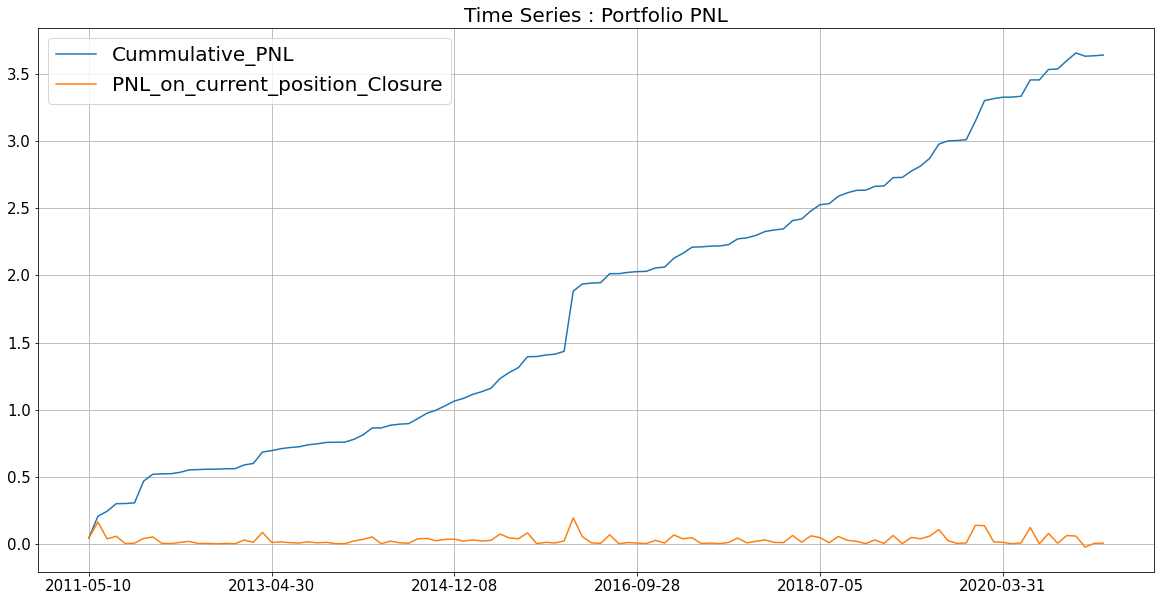

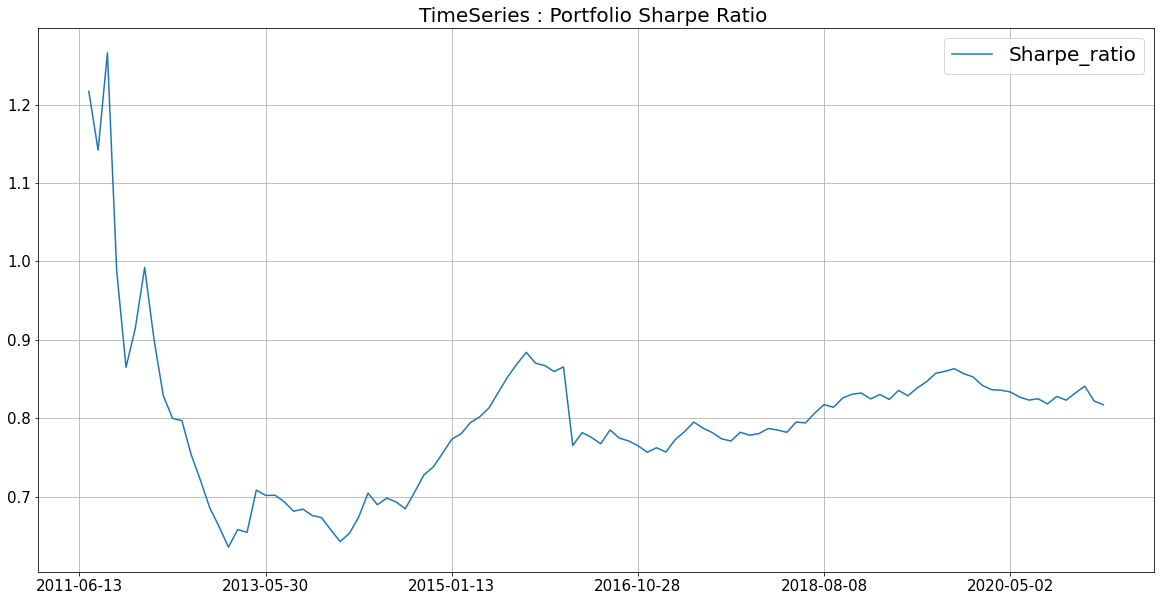

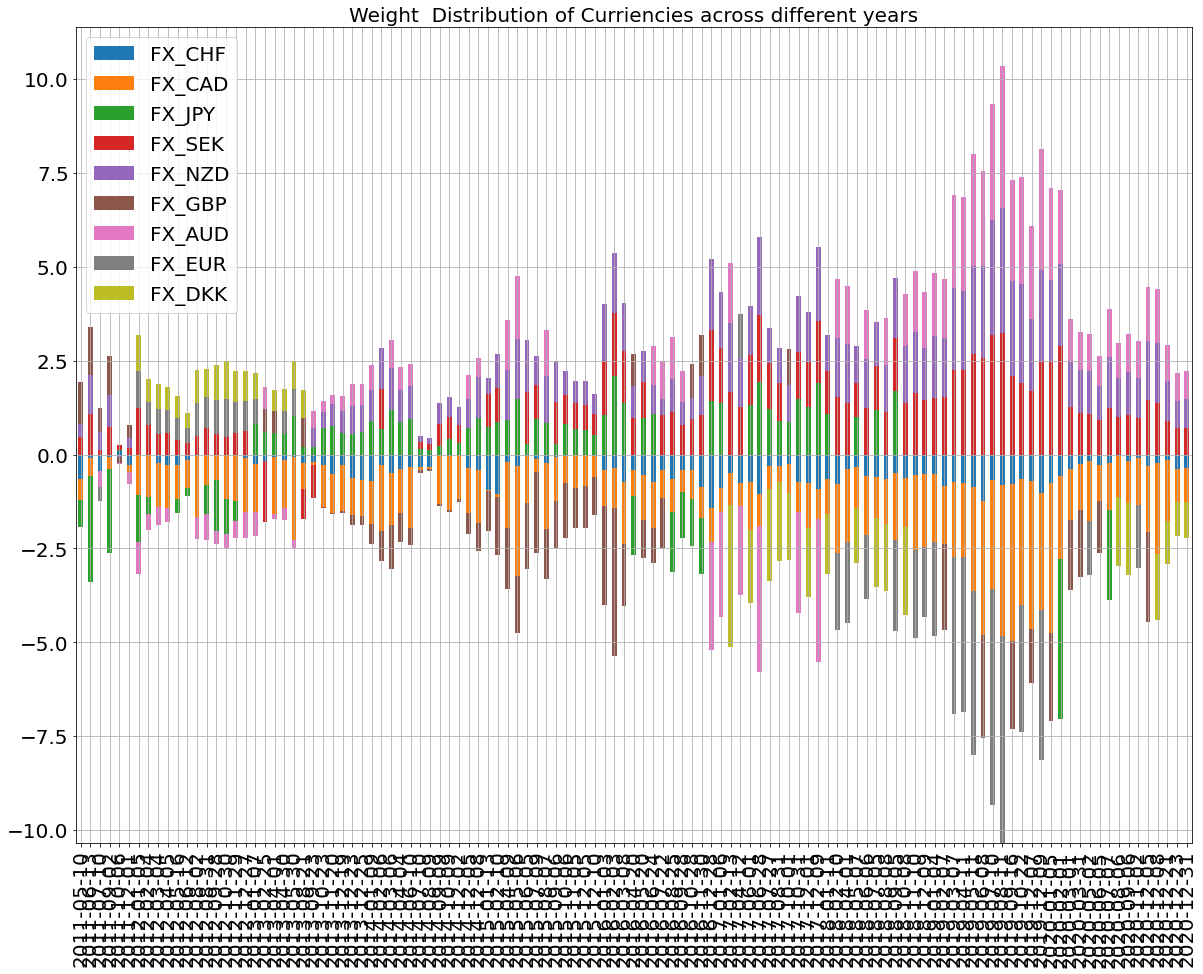

In [86]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates

figure(figsize=(10,10), dpi=100)
plt.rcParams['figure.figsize'] = [20,10]
stats_ = dict()
for i,j in mom_["Details"].items():
    
    stats_[i] = {"Portfolio_STD": mom_["Details"][i]["Portfolio_STD"],  \
                 "PNL_on_current_position_Closure": mom_["Details"][i]["PNL_on_current_position_Closure"],\
                 "Cummulative_PNL" : mom_["Details"][i]["Total_Running_PNL"], \
                 "Portfolio_Max":    mom_["Details"][i]["Portfolio_Max"], \
                 "Portfolio_Min":    mom_["Details"][i]["Portfolio_Min"]}

PNL_ = pd.DataFrame.from_dict(stats_).T
PNL_all = PNL_ 

PNL_all = PNL_all[PNL_all.PNL_on_current_position_Closure!= 0].dropna(axis=0)
PNL_all.to_csv("PORTFOLIO_PNL.csv")
PNL_all[["Cummulative_PNL","PNL_on_current_position_Closure"]].plot()
plt.tick_params(labelsize=15)
plt.title("Time Series : Portfolio PNL",fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()


## Sharpe Ratio
PNL_all.index = pd.to_datetime(PNL_all.index)
PNL_all = PNL_all[PNL_all.PNL_on_current_position_Closure !=0].dropna()
x = PNL_all[["PNL_on_current_position_Closure"]].pct_change().dropna()
sharpe_ratio = {}

for i in range(1,len(PNL_all)):
    _date = str(PNL_all.index[i]).replace("00:00:00","").strip() 
    _std = PNL_all["PNL_on_current_position_Closure"][0:i].std()
    _mean = PNL_all["PNL_on_current_position_Closure"][0:i].mean()
    sharpe_ratio[_date] = { "Sharpe_ratio" : _mean/_std}

    
pd.DataFrame(sharpe_ratio).T.plot( title = "TimeSeries : Portfolio Sharpe Ratio ")
plt.title("TimeSeries : Portfolio Sharpe Ratio ",fontsize=20)
plt.tick_params(labelsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()


## weight 
investment = pd.DataFrame()
for i,j in mom_["Details"].items():
     df_ = pd.DataFrame(mom_['Details'][i]['Investment'].T.values, index = [i],  \
                        columns = mom_['Details'][i]['Investment'].T.columns )
     investment = pd.concat([investment,df_],ignore_index = False, axis =0)
    
investment = investment.fillna(0)
investment 
## Graph 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#figure(figsize=(50,40), dpi=80)
plt.rcParams['figure.figsize'] = [280,280]
"""df=pd.DataFrame(investmnet_df.values,index=investmnet_df.index)
df.columns = investmnet_df.columns"""
#investment = investment.reset_index()
#investment.index[0]
#investment.index = investment.index.map(lambda t: t.strftime('%Y-%m-%d'))
investment.plot(kind="bar",stacked=True,figsize=(20,15))
plt.legend(loc="lower down")
plt.title("Weight  Distribution of Curriencies across different years",fontsize=20)
plt.tick_params(labelsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

## Portfolio PNL Data 

In [90]:
investment.head(50)

,FX_CHF,FX_CAD,FX_JPY,FX_SEK,FX_NZD,FX_GBP,FX_AUD,FX_EUR,FX_DKK
2011-05-10,-0.654603,-0.567587,-0.704683,0.474591,0.338955,1.113328,0.000000,0.000000,0.000000
2011-06-13,-0.090302,-0.486406,-2.810624,1.078594,1.035187,1.273551,0.000000,0.000000,0.000000
2011-07-10,-0.426472,0.000000,0.000000,0.111508,0.489872,0.648392,-0.427197,-0.396103,0.000000
2011-09-02,-0.061417,-0.315772,-2.249757,0.732329,0.865002,1.029615,0.000000,0.000000,0.000000
2011-10-06,0.084400,0.000000,0.043488,0.127856,-0.072643,-0.159200,-0.023903,0.000000,0.000000
2011-12-01,-0.291820,-0.187001,0.000000,0.164347,0.263699,0.367720,-0.316944,0.000000,0.000000
2012-01-05,0.000000,-1.067147,-1.258529,1.244748,0.000000,0.000000,-0.866440,0.992303,0.955065
2012-02-04,0.000000,-1.132896,-0.457658,0.784993,0.000000,0.000000,-0.415821,0.619818,0.601564
2012-03-04,-0.235495,-1.152423,0.000000,0.550539,0.000000,0.000000,-0.483380,0.666956,0.653802
2012-04-05,-0.267524,-1.162090,0.000000,0.567203,0.000000,0.000000,-0.358580,0.617099,0.603893


# Strategy 4: Value Strategy -  Dollar Neutral

## 1. Import List of Libraries 

In [ ]:
import pandas as pd
import numpy  as  np
from datetime import datetime, timedelta

## Final Portfolio Optimization code 
from cvxpy import *
import cvxpy as cp

import pandas as pd
import numpy as np

from datetime import datetime, timedelta
#from yahoo_finance import Share
import random
import warnings

warnings.simplefilter(action="ignore")

## 4.1 Upload Files - FX Rates  - G10 Currencies 

In [ ]:
fx_nominal_df = pd.read_csv("G10_FX_CLOSE.csv")
fx_nominal_df ["DATE"] = pd.to_datetime(fx_nominal_df["DATE"])
fx_nominal_df  =fx_nominal_df .set_index('DATE')
fx_nominal_df  = fx_nominal_df .iloc[:,-10:-1]
fx_nominal_df = fx_nominal_df.sort_index(ascending=True)
fx_nominal_df.columns = fx_nominal_df.columns.str.strip()
fx_real_df  = fx_nominal_df.copy()
fx_nominal_df.index.year.unique()

## 4.2 Upload Files - PPP Rates  - G10 Countries  

In [ ]:
ppp_df = pd.read_csv("PPP.csv")
ppp_df['Year']=pd.to_datetime(ppp_df["Year"], format='%Y')
ppp_df = ppp_df.set_index('Year')
ppp_df.index = ppp_df.index.year
ppp_df.head(2)
fx_df_nominal = fx_nominal_df.copy()
ppp_df.columns
ppp_df.index.unique()
ppp_df  = ppp_df.sort_index(ascending=True)
ppp_df.columns = ppp_df.columns.str.strip()

## 4.3 Convert Nominal FX rates into real interest rates --> Nominal / ppp

In [ ]:
for i in fx_real_df.index.year.unique():
    for j in fx_real_df.columns:
        fx_real_df[j][fx_real_df.index.year == i]  \
        = (fx_real_df[j][fx_real_df.index.year == i])/(ppp_df[j][ppp_df.index == int(i-1)].values)

## 4.4 Function : Split Data & Generate Trading Signal  -  T-Stat

In [ ]:
from sklearn.preprocessing import StandardScaler
def test_train_df(df_,test_start:int,test_end:int):
    
    # Data Split   -  Nominal Rates 
    
    df_train = df_[(df_.index.year <= test_start-1)]
    df_train= df_train.sort_index()
    
    df_test = df_[(df_.index.year >= test_start) & (df_.index.year <=test_end)]
    df_test.index = df_test.sort_index()

    # Data Split - Real  - Test Data
    #fx_real_df_train =   fx_real_df[(fx_real_df.index.year <= test_start-1)]
    #fx_real_df_test  = fx_real_df.iloc[(fx_real_df.index.year >= test_start) & (fx_real_df.index.year <= test_end)]
    
    return {"Train":df_train,"Test":df_test}

from sklearn.preprocessing import StandardScaler
def GetTradingSignal(Close_price):
    '''
    TREND Trading Signal
    - Uses the t-statistics of historical daily log-returns to reflect the strength of price movement trend
    - TREND Signal Conditions:
    t-stat > 1 => TREND Signal = 1
    t-stat < 1 => TREND Signal = -1
    -1 < t-stat < 1 => TREND Signal = t-stat
    '''
    log_returns = np.log(Close_price/Close_price.shift(1)).dropna()
    mean = np.mean(log_returns)
    std = np.std(log_returns)
    n = len(log_returns)
    t_stat = mean/(std/np.sqrt(n))

    # cap holding at 1 and -1
    return np.clip(t_stat, a_max=1, a_min=-1)

## 4.6 Function :  get list of undervalued and Overvalued currencies & Construct DataFrame 

In [ ]:
def UnderValuedCurrencies(Curdata):
    return GetTradingSignal(Curdata).sort_values(ascending = True).head(3)

def OvervaluedCurrencies(Curdata):
    return GetTradingSignal(Curdata).sort_values(ascending = False).head(3)

def OverValued_Under_Valued_df(df):
    over_v = df[OvervaluedCurrencies(df).index.values]
    under_v = df[UnderValuedCurrencies(df).index.values]
    return pd.concat([over_v,under_v],axis =1,ignore_index = False)


## 4.8 Dollar Neutral Portfolio Creation 


Action / Currency / Variable 
    1. Buy : JPY->  w[0]
    2. BUy : AUD ->  w[1] 
    3. Buy : CAD ->  w[2] 
    4. Sell :GBP  -> w[3]
    5. Sell :NZD  -> w[4]
    6. Sell : CHF -> w[5] 

- Constraints 

    1. w[0],w[1],w[2] ->  Sell and   w[3],w[4],w[5] : Buy
    2. Sum of Long currencies wieght <=0.50
    3. Sum of Song currencies wieght <=0.50
    4. Weight of Short  currencies  w >= -0.5,w <= 0
    5. Weight of Long   currenciesw w >= 0,w <= 0.5
   

- Optimization: 
    * Maximize ( expected Retrun - Gamma * Risk)




## 4.9 Function : Weight Generation  : High Return Portolio ( Lowest Sharp Ratio )  & Portfolio _ PNL Caclulation 

In [ ]:
def portfolioWeights(df_,test_start,test_end):
    exp_return = 0.4 

    ## Gather real Exchange rates 
    train_data_real_fx = test_train_df(df_,test_start,test_end)['Train']
    
    print("Read Exchange rates - Training Data for period end on {}  is {}\n".format (test_start,train_data_real_fx.head(2)))
    
    ## Undervalued 
    list_undevalue = UnderValuedCurrencies(test_train_df(df_,test_start,test_end)['Train'])
    list_overvalue = OvervaluedCurrencies(test_train_df(df_,test_start,test_end)['Train'])
    
    print("\nOvervalue Currencies \n {}".format(list_undevalue.index.values))
    print("\nUndervalue Currencies \n {}".format(list_overvalue.index.values))
    

    over_v = train_data_real_fx[OvervaluedCurrencies(train_data_real_fx).index.values]
    under_v = train_data_real_fx[UnderValuedCurrencies(train_data_real_fx).index.values]
    
    overvalued_undervalued_data = pd.concat([over_v,under_v],axis =1,ignore_index = False)
    #overvalued_undervalued_data = pd.concat([under_v,over_v],axis =1,ignore_index = False)
    print("\nOvervalued_Undervalued_data : \n : {}".format(overvalued_undervalued_data.head(2)))
    
    ## Percentage Change
    df_return = overvalued_undervalued_data.pct_change().dropna()
    
    print("\nDaily return :\n {}".format(df_return.head(2)))

    ## Convariance 
    cov_mat = overvalued_undervalued_data.cov()
    
    print("\nCovariance matrix : \n {}".format(cov_mat.head(2)))
    Sigma = cov_mat.values # np.asarray(cov_mat.values)

    print("\nSigma:\n {}".format(Sigma))
    
    ## Varaible Creation 
    w = cp.Variable(len(overvalued_undervalued_data.columns))
    
    print("\nVariable creation:{} ".format(len(overvalued_undervalued_data.columns)))
    
    ## mu 
    mu = np.array([exp_return]*len(cov_mat)) # mu is the vector of expected returns.
    
    print ("\nMu calculation :  \n {}".format(mu))
    mu = mu.reshape(-1,1)

    ## Expected Return 
    expected_return = mu.T@w 


    num_stocks = len(cov_mat)
    gamma = Parameter(nonneg=True)
    gamma.value = 1

    ## Risk Calculation 
    risk = quad_form(w, Sigma)

    
    ## Constraints 
    opt_constraints = [w[0] >= -0.5,w[0] <= -0.1,\
                       w[1] >= -0.5,w[1] <= -0.1,\
                       w[2] >= -0.5,w[2] <= -0.1,\
                       w[3] >= 0,w[3] <= 0.5,\
                       w[4] >= 0,w[4] <= 0.5,\
                       w[5] >= 0,w[5] <= 0.5, \
                       sum([w[0],w[1],w[2]]) == -0.50,\
                       sum([w[3],w[4],w[5]]) == 0.50] 
     


    ## Maximize -> Maximize(expected_return - gamma*risk)
    prob = cp.Problem(cp.Maximize(expected_return - gamma*risk),constraints=opt_constraints)
    prob.solve(qcp=True)

    weights_value_df = pd.DataFrame([w[0].value,w[1].value,w[2].value,w[3].value,w[4].value,w[5].value],index = overvalued_undervalued_data.columns)

    weights_value_df = weights_value_df.rename(columns = {0 : "Weight"})

    return weights_value_df



def PNL(pnl_,total_cash,weight,commission):
    Total_Cash = 1
    Value_fx_Value_df_return = pd.DataFrame()
    Value_fx_Value_df_return = Value_fx_Value_df_return .iloc[0:0]
    
    ## Percentage change 
    Value_fx_Value_df_return = pnl_[weights_value_df.index].pct_change().dropna(axis =0)
    
    
    Value_fx_Value_df_return.index  = Value_fx_Value_df_return.sort_index(ascending = True)
    
    for i in weights_value_df.index:
        print("Currency : {} , Currency Weight {} ".format(i,weights_value_df.loc[i][0]*Total_Cash))
        Value_fx_Value_df_return["PNL_"+i] = Value_fx_Value_df_return[i].apply(lambda x : x * (weights_value_df.loc[i][0]*Total_Cash))

     
    print("Total Weight  : Long - Short : {}".format(weights_value_df.sum()))
    
    
    print("\n \n CUMULATIVE PNL - ACROSS DIFFERENT YEARS")  
    print("------------------------------------------------")
    PNLPortfolio_= Value_fx_Value_df_return.loc[:, Value_fx_Value_df_return.columns.str.startswith('PNL')]
    PNLPortfolio_["PNL_Portfolio"] = PNLPortfolio_.sum(axis =1)
   
    for i in PNLPortfolio_.index.year.unique().sort_values(ascending = True):
        print("\nCummulative PNL - year {} : {} ".format( i,\
        PNLPortfolio_[["PNL_Portfolio"]][PNLPortfolio_["PNL_Portfolio"].index.year == i].resample('Y').last().iloc[0][0]))
    
    print("*********PNL FILE SAVE***************")
    PNLPortfolio_.to_csv("portfolio_CumulativePNL.csv")
    PNL_amount = PNLPortfolio_[["PNL_Portfolio"]][PNLPortfolio_["PNL_Portfolio"].index.year == PNLPortfolio_["PNL_Portfolio"].index.year.max()].resample('Y').last().iloc[0][0]
    return PNLPortfolio_

In [ ]:
import numpy as np
import scipy.sparse as sp
np.random.seed(1)
n = 10
mu = np.abs(np.random.randn(n, 1))
Sigma = np.random.randn(n, n)
Sigma = Sigma.T.dot(Sigma)
Sigma

## 5.1 Function : Graph Plot  

In [ ]:
def graph(df_):
    fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(30,30))
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

    print("\n\nGraphs")
    plt.legend(loc='lower right', ncol=2)
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=24)
    
    df_["PNL_Portfolio"].plot(title = "Daily Cumulative PNL - Portfolio  " ,ax=axes[0,0])
    plt.tick_params(labelsize=24)
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=14)
    
    plt.legend(loc='lower right', ncol=2)
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=24)
    
    df_.iloc[:,:-1].plot(title = "Daily Individual Currency PNL",ax=axes[0,1])
    plt.legend(loc='lower right', ncol=2)
    plt.tick_params(labelsize=84)
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=14)

    
    df_["PNL_Portfolio"].resample('M').last().plot(title = "Monthly - Cumulative Portfolio PNL" ,ax=axes[1,0])
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=14)
   
    df_.iloc[:,:-1].resample('M').last().plot(title = "Monthly - Cumulative Individual Currency PNL",ax=axes[1,1])
    plt.legend(loc='lower right', ncol=2)
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=24)
    
    
    df_["PNL_Portfolio"].resample('Y').last().plot(title = "Yearly - Cumulative Portfolio PNL" ,ax=axes[2,0])
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=14)
    
    
    df_.iloc[:,:-1].resample('Y').last().plot(title = "Yearly - Cumulative Individual Currency PNL",ax=axes[2,1])
    plt.legend(loc='lower right', ncol=2)
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=24)
    

# 5.2 Execution  -  Execution Of Value Strategy 

In [ ]:
weights_value_df=portfolioWeights(fx_nominal_df,2012,2020)
fx_df_nominal_test = test_train_df(fx_nominal_df,2012,2020)['Test']
PNLPortfolio_ = PNL(fx_df_nominal_test,1,weights_value_df,0.000002)
graph(PNLPortfolio_)

    

## COMBINE

### Combined Strategies

In [ ]:
t_strategy = history_sum
t_strategy_value_signal = t_strategy.cumsum()

t_strategy_money = t_strategy*-s_rate   
t_strategy_money = t_strategy_money.sum(axis=1)-abs(t_strategy*s_rate*TRANS_FEE).sum(axis=1)
t_strategy_money = t_strategy_money.cumsum()

t_strategy_valule = t_strategy_value_signal*s_rate
t_strategy_valule = t_strategy_valule.sum(axis=1)

t_strategy_pnl = t_strategy_money+t_strategy_valule

'''
t_strategy_pnl_pct=(t_strategy_pnl+1).pct_change()
t_strategy_pnl_pct=t_strategy_pnl_pct.replace([np.inf, -np.inf], np.nan)
t_strategy_pnl_pct=t_strategy_pnl_pct.fillna(0)
'''

t_strategy_pnl.index = pd.to_datetime(t_strategy_pnl.index)
plt.show()

In [ ]:
"""combine two strategies """
money_signal = signal
value_signal = money_signal.cumsum()

combine_money_signal = money_signal+t_strategy #money is when you close the position what you earn from that
combine_value_signal = value_signal+t_strategy.cumsum() #value is that you hold a position, if the price change, the value of your protofilio will change

money_pnl = combine_money_signal*-s_rate   
money_pnl = money_pnl.sum(axis=1)-abs(combine_money_signal*s_rate*TRANS_FEE).sum(axis=1)
money_pnl = money_pnl.cumsum()

value_pnl = combine_value_signal*s_rate
value_pnl = value_pnl.sum(axis=1)


Combined_pnl = money_pnl + value_pnl
'''
Combined_pnl_pct=(Combined_pnl+1).pct_change()
Combined_pnl_pct=Combined_pnl_pct.replace([np.inf, -np.inf], np.nan)
Combined_pnl_pct=Combined_pnl_pct.fillna(0)
'''

Combined_pnl.index = pd.to_datetime(Combined_pnl.index)

In [ ]:
plt.plot(pairs_pnl,label='pairs trade     SR:'+str(round(sharpe_ratio_pairs,4)))
#plt.plot(pairs_pnl,label='pairs trade')
plt.plot(Combined_pnl,label = 'combined strategy    SR:'+str(round(Combined_pnl.mean()/Combined_pnl.std(),4)))
#plt.plot(Combined_pnl,label = 'combined strategy')
plt.plot()
plt.legend()
plt.show()

In [ ]:
plt.plot(pairs_pnl,label='pairs trade     SR:'+str(round(sharpe_ratio_pairs,2)))
#plt.plot(pairs_pnl,label='pairs trade')
plt.plot(Combined_pnl,label = 'combined strategy    SR:'+str(round(Combined_pnl.mean()/Combined_pnl.std(),4)))
#plt.plot(Combined_pnl,label = 'combined strategy')


pnl_series=[]
sharpe_series={}
pairs_pnl=[0]*N
signal = pd.DataFrame([[0]*10 for _ in range(N)],index=base.index,columns=namelist)

# polt the whole pairs
for i in range(len(pairs)):
    indexS1 = namelist.index(pairs[i][0])
    indexS2 = namelist.index(pairs[i][1])
    pnl,temp = trade(s_rate[pairs[i][0]].iloc[:N],
                     s_rate[pairs[i][1]].iloc[:N],indexS1,indexS2,5, 60)
    signal += temp
    pairs_pnl=list(map(lambda x,y:x+y,pnl,pairs_pnl))
    pnl.index = pd.to_datetime(pnl.index)

    return_pnl = np.array((pnl+1).diff(1)[1:])/np.array((pnl[:-1]+1))
    sharpe_ratio = return_pnl.mean()/return_pnl.std()
    pnl_series.append(return_pnl)
    sharpe_series[pairs[i]]=sharpe_ratio
    plt.plot(pnl,label=str(pairs[i])+'   SR:'+str(round(sharpe_ratio,4)))

plt.legend()
plt.show()

### Combined Strategies Performance Results

In [ ]:
"""sharpe ratio""" 
print ("Transaction Fee: %.4f" %TRANS_FEE)
print ("Pairs Trade return: %.4f, Pairs Trade sharpe ratio: %.4f" %(pairs_pnl[-1],sharpe_ratio_pairs))
print ("Carry Trade return: %.4f, Carry Trade sharpe ratio: %.4f" %(t_strategy_pnl[-1], cal_sharpe(history_sum,total_cf_allq,s))) 
print ("Combined Strategy return: %.4f, Combined Strategy sharpe ratio: %.4f" %(Combined_pnl[-1],Combined_pnl.mean()/Combined_pnl.std()))

In [ ]:
"""output position,pnl"""
#strategy_net_val = pd.concat([pairs_pnl,t_strategy_pnl,Combined_pnl],axis=1)
#strategy_net_val.columns = ['pair_trading','t_strategy','combined']
#strategy_net_val.to_csv("strategy_net_value.csv")
#combine_value_signal.to_csv("position_daily.csv")

In [ ]:
### Combined Strategies

t_strategy = history_sum
t_strategy_value_signal = t_strategy.cumsum()

t_strategy_money = t_strategy*-s_rate   
t_strategy_money = t_strategy_money.sum(axis=1)-abs(t_strategy*s_rate*TRANS_FEE).sum(axis=1)
t_strategy_money = t_strategy_money.cumsum()

t_strategy_valule = t_strategy_value_signal*s_rate
t_strategy_valule = t_strategy_valule.sum(axis=1)

t_strategy_pnl = t_strategy_money+t_strategy_valule

'''
t_strategy_pnl_pct=(t_strategy_pnl+1).pct_change()
t_strategy_pnl_pct=t_strategy_pnl_pct.replace([np.inf, -np.inf], np.nan)
t_strategy_pnl_pct=t_strategy_pnl_pct.fillna(0)
'''

t_strategy_pnl.index = pd.to_datetime(t_strategy_pnl.index)
plt.show()

"""combine two strategies """
money_signal = signal
value_signal = money_signal.cumsum()

combine_money_signal = money_signal+t_strategy #money is when you close the position what you earn from that
combine_value_signal = value_signal+t_strategy.cumsum() #value is that you hold a position, if the price change, the value of your protofilio will change

money_pnl = combine_money_signal*-s_rate   
money_pnl = money_pnl.sum(axis=1)-abs(combine_money_signal*s_rate*TRANS_FEE).sum(axis=1)
money_pnl = money_pnl.cumsum()

value_pnl = combine_value_signal*s_rate
value_pnl = value_pnl.sum(axis=1)


Combined_pnl = money_pnl + value_pnl
'''
Combined_pnl_pct=(Combined_pnl+1).pct_change()
Combined_pnl_pct=Combined_pnl_pct.replace([np.inf, -np.inf], np.nan)
Combined_pnl_pct=Combined_pnl_pct.fillna(0)
'''

Combined_pnl.index = pd.to_datetime(Combined_pnl.index)

plt.plot(pairs_pnl,label='pairs trade     SR:'+str(round(sharpe_ratio_pairs,4)))
#plt.plot(pairs_pnl,label='pairs trade')
plt.plot(Combined_pnl,label = 'combined strategy    SR:'+str(round(Combined_pnl.mean()/Combined_pnl.std(),4)))
#plt.plot(Combined_pnl,label = 'combined strategy')
plt.plot()
plt.legend()
plt.show()

plt.plot(pairs_pnl,label='pairs trade     SR:'+str(round(sharpe_ratio_pairs,2)))
#plt.plot(pairs_pnl,label='pairs trade')
plt.plot(Combined_pnl,label = 'combined strategy    SR:'+str(round(Combined_pnl.mean()/Combined_pnl.std(),4)))
#plt.plot(Combined_pnl,label = 'combined strategy')


pnl_series=[]
sharpe_series={}
pairs_pnl=[0]*N
signal = pd.DataFrame([[0]*10 for _ in range(N)],index=base.index,columns=namelist)

# polt the whole pairs
for i in range(len(pairs)):
    indexS1 = namelist.index(pairs[i][0])
    indexS2 = namelist.index(pairs[i][1])
    pnl,temp = trade(s_rate[pairs[i][0]].iloc[:N],
                     s_rate[pairs[i][1]].iloc[:N],indexS1,indexS2,5, 60)
    signal += temp
    pairs_pnl=list(map(lambda x,y:x+y,pnl,pairs_pnl))
    pnl.index = pd.to_datetime(pnl.index)

    return_pnl = np.array((pnl+1).diff(1)[1:])/np.array((pnl[:-1]+1))
    sharpe_ratio = return_pnl.mean()/return_pnl.std()
    pnl_series.append(return_pnl)
    sharpe_series[pairs[i]]=sharpe_ratio
    plt.plot(pnl,label=str(pairs[i])+'   SR:'+str(round(sharpe_ratio,4)))

plt.legend()
plt.show()

### Combined Strategies Performance Results

"""sharpe ratio""" 
print ("Transaction Fee: %.4f" %TRANS_FEE)
print ("Pairs Trade return: %.4f, Pairs Trade sharpe ratio: %.4f" %(pairs_pnl[-1],sharpe_ratio_pairs))
print ("Carry Trade return: %.4f, Carry Trade sharpe ratio: %.4f" %(t_strategy_pnl[-1], cal_sharpe(history_sum,total_cf_allq,s))) 
print ("Combined Strategy return: %.4f, Combined Strategy sharpe ratio: %.4f" %(Combined_pnl[-1],Combined_pnl.mean()/Combined_pnl.std()))

"""output position,pnl"""
#strategy_net_val = pd.concat([pairs_pnl,t_strategy_pnl,Combined_pnl],axis=1)
#strategy_net_val.columns = ['pair_trading','t_strategy','combined']
#strategy_net_val.to_csv("strategy_net_value.csv")
#combine_value_signal.to_csv("position_daily.csv")